In [1]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

In [2]:
#@save
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = '../data/VOCdevkit/VOC2012'

In [3]:
def read_voc_images(voc_dir, is_train=True):
    '''读取所有VOC图像并标注'''
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation', 'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(voc_dir, 'JPEGImages', fname + '.jpg'), mode=mode))
        labels.append(torchvision.io.read_image(os.path.join(voc_dir, 'SegmentationClass', fname + '.png'), mode=mode))
    return features, labels

In [4]:
train_features, train_labels = read_voc_images(voc_dir, True)

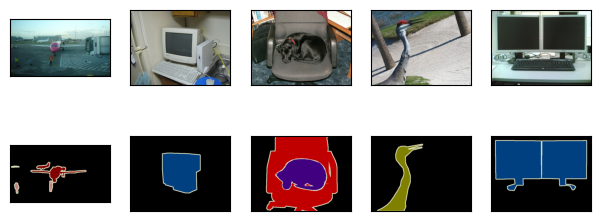

In [5]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
imgs = [img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs, 2, n);

In [6]:
# 列举RGB颜色值和类名

#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [7]:
# 相当于一个哈希表

def voc_colormap2label():
    '''构建从RGB到VOC类别索引的映射'''
    colormap2label = torch.zeros(256**3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0] * 256) + (colormap[1] * 256) + colormap[2]] = i
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    '''将RGB颜色映射到VOC类别索引'''
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256) + (colormap[:, :, 1] * 256) + colormap[:, :, 2])
    return colormap2label[idx]


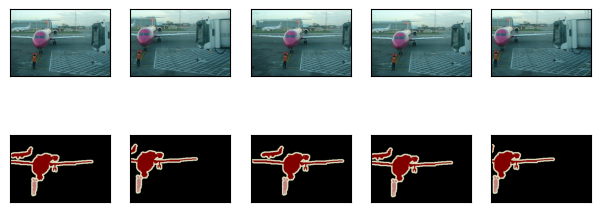

In [8]:
def voc_rand_crop(feature, label, height, width):
    '''随机裁剪图像和标签'''
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, output_size=(height, width))
    # torchvision.transforms.RandomCrop.get_params 返回的元组，表示随机裁剪区域的位置和大小
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

In [9]:
class VOCSegDataset(torch.utils.data.Dataset):
    '''一个用于加载VOC数据集的PyTorch数据集类'''

    def __init__(self, is_train, crop_size, _voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean= [0.485, 0.456, 0.406],
            std= [0.229, 0.224, 0.225]
        )
        self.crop_size = crop_size
        features, labels = read_voc_images(_voc_dir, is_train)
        self.features = [self.normalize(feature) for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read' + str(len(self.features)) + ' examples')

    def normalize(self, img):
        '''对图像进行归一化处理'''
        img = img.float() / 255
        img = self.transform(img)
        return img

    def filter(self, imgs):
        '''过滤掉不符合要求的图像
        只保留宽度和高度都大于等于裁剪大小的图像'''
        return [img for img in imgs if img.size(1) >= self.crop_size[0] and img.size(2) >= self.crop_size[1]]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx], *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))
    

In [10]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read1114 examples
read1078 examples


In [11]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=0)
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


In [12]:
def load_data_voc(batch_size, crop_size=(320, 480)):
    '''加载VOC语义分割数据集'''
    voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
    num_workers = d2l.get_dataloader_workers() # 多进程
    train_iter = torch.utils.data.DataLoader(VOCSegDataset(True, crop_size, voc_dir), batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(VOCSegDataset(False, crop_size, voc_dir), batch_size, shuffle=False,
                                   drop_last=False,
                                   num_workers=num_workers)
    return train_iter, test_iter